### Backtesting on Korean Commodity (Gold mini)

In [26]:
from zipline import run_algorithm
import matplotlib.pyplot as plt
import math
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent, order, schedule_function,  date_rules,time_rules
from zipline.finance import commission
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
#from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [28]:
%matplotlib inline 
%load_ext zipline
%load_ext autoreload
%autoreload 2

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
calendar_name = 'XKRX'
calendar = get_calendar(calendar_name)
calendar

### funtion for the graph

In [33]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    #stats = [math.log(result.rolling_sharpe.mean())/result.rolling_sharpe.std(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    #rolling_sharpe = result["rolling_sharpe"].dropna().values

    if (result["rolling_sharpe"].dropna().values <= 0).any():
        # Handle case where Sharpe ratio is non-positive
        stats = [float('nan'), result.portfolio_value.mean(), result.rolling_vol.mean()]
    else:
        stats = [math.log(rolling_sharpe.mean())/rolling_sharpe.std(), result.portfolio_value.mean(), result.rolling_vol.mean()]

    return result, stats



def show_rolling_stats(result, r_window, buy_signal=None, sell_signal=None):
    result, stats = get_rolling_stats(result, r_window)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Plot rolling sharpe ratio
    result["rolling_sharpe"].plot(ax=ax[0], title="Rolling sharpe")
    ax[0].axhline(0, color="red", ls="--")

    # Plot rolling volatility
    result["rolling_vol"].plot(ax=ax[1], title="Rolling vol")

    # Create a new figure and plot BTC price and portfolio value in separate subplots
    fig2, ax2 = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    # Plot BTC price in the first subplot
    result[["Kor_gold"]].plot(ax=ax2[0], color="green", label="Kor_gold Price")
    ax2[0].set_title("Kor_gold Price")
    ax2[0].set_ylabel("Kor_gold Price")

    # Plot buy and sell signals as dots in the BTC price subplot
    if buy_signal is not None:
        buy_mask = buy_signal == True
        result.loc[buy_mask, "Kor_gold"].plot(
            ax=ax2[0], 
            color="yellow", 
            marker="^",
            linestyle='None',
            label="Long (buy)"
        )

    if sell_signal is not None:
        sell_mask = sell_signal == True
        result.loc[sell_mask, "Kor_gold"].plot(
            ax=ax2[0], 
            color="red", 
            marker="v",
            linestyle='None',
            label="Short (sell)"
        )

    # Add legend to the subplot
    ax2[0].legend()

    # Plot portfolio value in the second subplot
    ax2[1].set_title("Portfolio value")
    ax2[1].set_ylabel("Portfolio value")
    result["portfolio_value"].plot(ax=ax2[1], color="blue", label="Portfolio value")

    # Add legend to the subplot
    ax2[1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

    return result



### MACD

In [36]:

def EMA(day, price_hist):
    #price_hist = price_hist.tolist()
    multiplier = 2 / (day + 1)
    EMA_list = []
    EMA_prev = price_hist[0]
    EMA_list.append(EMA_prev)
    for price in price_hist[1:]:
        EMA = (price - EMA_prev) * multiplier + EMA_prev
        EMA_list.append(EMA)
        EMA_prev = EMA
    return EMA_list


In [38]:

def initialize(context):
    context.i = 0
    context.asset = symbol("Kor_gold_mod")


def handle_data(context, data):
    context.i += 1
    if context.i < 1:
        return
    buy_signal = False
    sell_signal = False
    price_hist = data.history(context.asset, 'close', bar_count =15, frequency ='1d')     # Ideally for MACD 26,12,9 days are used, I use here 14,7,5 days
    EMA_20 = EMA(14, price_hist)
    EMA_5 = EMA(7, price_hist)
    MACD = [EMA_20[i] - EMA_5[i] for i in range(len(price_hist))]
    signal = EMA(5,MACD)
    if MACD[-1] > signal[-1] and MACD[-2] < signal[-2]:    #Bull
        order(context.asset, 1)
        buy_signal = True
    elif MACD[-1] < signal[-1] and MACD[-2] > signal[-2]:  #Bear
        order(context.asset, -1)
        sell_signal = True
    record(
        Kor_gold=data.current(context.asset, "close"),
        MACD=MACD[-1],
        signal=signal[-1],
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=price_hist
    )

In [44]:
start_date = pd.to_datetime('2022-11-22', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2023-05-02', utc= True, format = '%Y-%m-%d %H:%M')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='Korea_commodity',
                            data_frequency='daily',
                            )

/tmp/ipykernel_10590/1834308575.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EMA_prev = price_hist[0]
/tmp/ipykernel_10590/1834308575.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EMA_prev = price_hist[0]
/home/yakub/anaconda3/lib/python3.9/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
/tmp/ipykernel_10590/18343

In [42]:
results

,period_open,period_close,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,short_exposure,...,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label
2022-11-22 06:30:00+00:00,2022-11-22 00:01:00+00:00,2022-11-22 06:30:00+00:00,0,0,0.0,0.0,0.0,0.000,0.000,0.0,...,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0,1,2022-11
2022-11-23 06:30:00+00:00,2022-11-23 00:01:00+00:00,2022-11-23 06:30:00+00:00,0,0,0.0,0.0,0.0,0.000,0.000,0.0,...,None,None,NaN,NaN,0.000000,0.000000,0.0,0.0,2,2022-11
2022-11-24 06:30:00+00:00,2022-11-24 00:01:00+00:00,2022-11-24 06:30:00+00:00,1,0,74700.0,0.0,74700.0,-37.351,-74737.351,0.0,...,None,None,-9.165151,-9.165151,-0.003735,7.498006,0.0,0.0,3,2022-11
2022-11-25 06:30:00+00:00,2022-11-25 00:01:00+00:00,2022-11-25 06:30:00+00:00,1,0,149160.0,0.0,149160.0,-157.291,-74617.291,0.0,...,None,None,-10.356018,-9.551378,-0.019464,15.212091,0.0,0.0,4,2022-11
2022-11-28 06:30:00+00:00,2022-11-28 00:01:00+00:00,2022-11-28 06:30:00+00:00,1,0,150200.0,0.0,150200.0,1040.000,0.000,0.0,...,None,None,5.491083,37.869017,-0.019464,15.212091,0.0,0.0,5,2022-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 06:30:00+00:00,2023-04-25 00:01:00+00:00,2023-04-25 06:30:00+00:00,1,0,255000.0,0.0,255000.0,1200.000,0.000,0.0,...,None,None,3.231695,5.427862,-0.350229,31.344572,0.0,0.0,107,2023-04
2023-04-26 06:30:00+00:00,2023-04-26 00:01:00+00:00,2023-04-26 06:30:00+00:00,1,0,256500.0,0.0,256500.0,1500.000,0.000,0.0,...,None,None,3.272300,5.496610,-0.350229,31.344572,0.0,0.0,108,2023-04
2023-04-27 06:30:00+00:00,2023-04-27 00:01:00+00:00,2023-04-27 06:30:00+00:00,1,0,256800.0,0.0,256800.0,300.000,0.000,0.0,...,None,None,3.267903,5.489434,-0.350229,31.344572,0.0,0.0,109,2023-04
2023-04-28 06:30:00+00:00,2023-04-28 00:01:00+00:00,2023-04-28 06:30:00+00:00,1,0,255600.0,0.0,255600.0,-1200.000,0.000,0.0,...,None,None,3.206857,5.386811,-0.350229,31.344572,0.0,0.0,110,2023-04


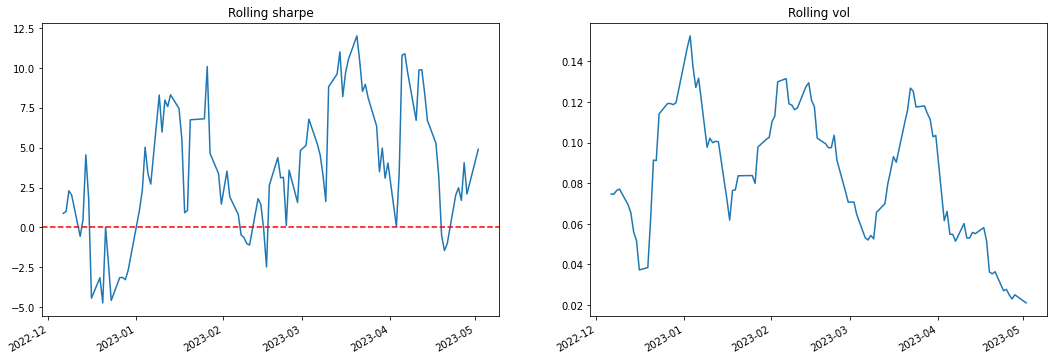

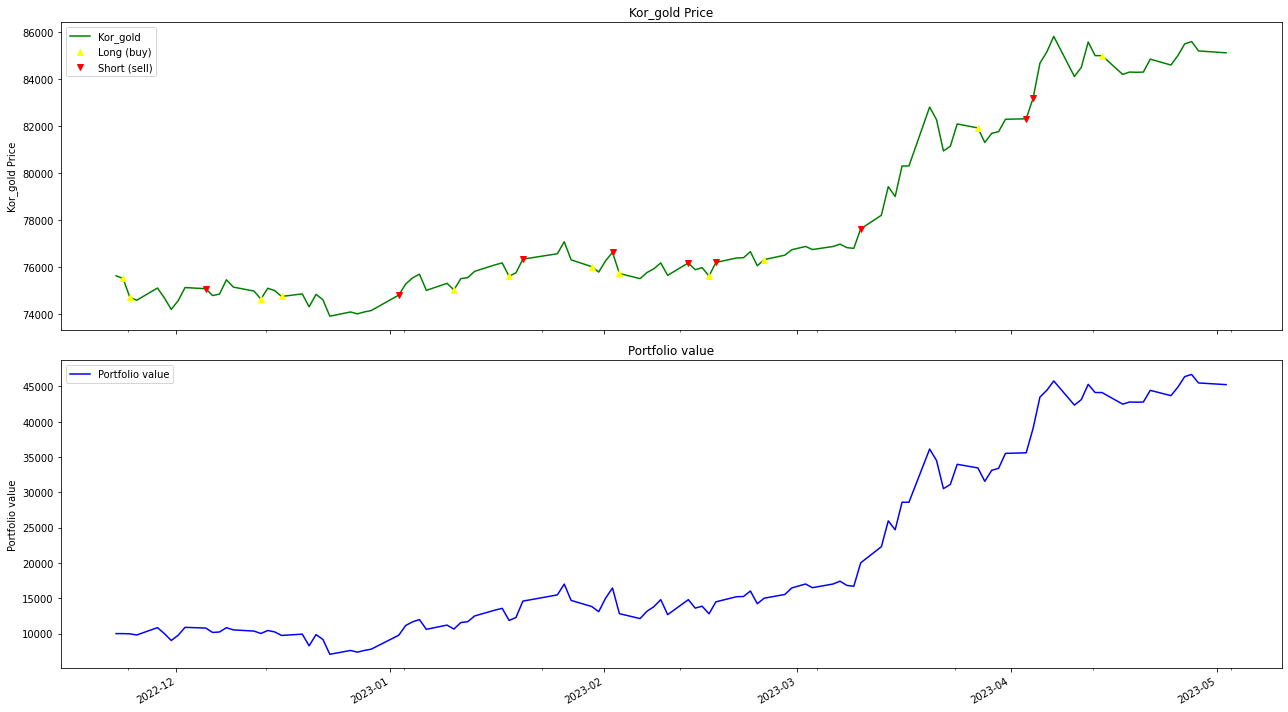

,period_open,period_close,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,short_exposure,capital_used,...,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,rolling_sharpe,rolling_vol
2022-11-22 06:30:00+00:00,2022-11-22 00:01:00+00:00,2022-11-22 06:30:00+00:00,0,0,0.0,0.0,0.0,0.000,0.0,0.000,...,NaN,0.000000,0.000000,0.0,0.0,1,2022-11,0.000000,NaN,NaN
2022-11-23 06:30:00+00:00,2022-11-23 00:01:00+00:00,2022-11-23 06:30:00+00:00,0,0,0.0,0.0,0.0,0.000,0.0,0.000,...,NaN,0.000000,0.000000,0.0,0.0,2,2022-11,0.000000,NaN,NaN
2022-11-24 06:30:00+00:00,2022-11-24 00:01:00+00:00,2022-11-24 06:30:00+00:00,1,0,74700.0,0.0,74700.0,-37.351,0.0,-74737.351,...,-9.165151,-0.003735,7.498006,0.0,0.0,3,2022-11,-0.003735,NaN,NaN
2022-11-25 06:30:00+00:00,2022-11-25 00:01:00+00:00,2022-11-25 06:30:00+00:00,1,0,149160.0,0.0,149160.0,-157.291,0.0,-74617.291,...,-9.551378,-0.019464,15.212091,0.0,0.0,4,2022-11,-0.019464,NaN,NaN
2022-11-28 06:30:00+00:00,2022-11-28 00:01:00+00:00,2022-11-28 06:30:00+00:00,1,0,150200.0,0.0,150200.0,1040.000,0.0,0.000,...,37.869017,-0.019464,15.212091,0.0,0.0,5,2022-11,0.084536,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 06:30:00+00:00,2023-04-25 00:01:00+00:00,2023-04-25 06:30:00+00:00,1,0,255000.0,0.0,255000.0,1200.000,0.0,0.000,...,5.427862,-0.350229,31.344572,0.0,0.0,107,2023-04,3.489968,2.485611,0.027755
2023-04-26 06:30:00+00:00,2023-04-26 00:01:00+00:00,2023-04-26 06:30:00+00:00,1,0,256500.0,0.0,256500.0,1500.000,0.0,0.000,...,5.496610,-0.350229,31.344572,0.0,0.0,108,2023-04,3.639968,1.696493,0.025077
2023-04-27 06:30:00+00:00,2023-04-27 00:01:00+00:00,2023-04-27 06:30:00+00:00,1,0,256800.0,0.0,256800.0,300.000,0.0,0.000,...,5.489434,-0.350229,31.344572,0.0,0.0,109,2023-04,3.669968,4.058993,0.023024
2023-04-28 06:30:00+00:00,2023-04-28 00:01:00+00:00,2023-04-28 06:30:00+00:00,1,0,255600.0,0.0,255600.0,-1200.000,0.0,0.000,...,5.386811,-0.350229,31.344572,0.0,0.0,110,2023-04,3.549968,2.098568,0.025095


In [43]:
show_rolling_stats(results, 10, buy_signal=results['buy_signal'], sell_signal=results['sell_signal'])


### tear_sheet using pyfolio

In [44]:
import pyfolio as pf

In [45]:
returns = results['returns']

/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/timeseries.py:734: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2022-11-22
End date,2023-05-02
Total months,5
,Backtest
Annual return,2980.65%
Cumulative returns,352.597%
Annual volatility,137.691%
Sharpe ratio,3.18
Calmar ratio,85.11
Stability,0.87
Max drawdown,-35.023%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.02,2022-12-02,2022-12-23,2023-01-03,23
1,28.71,2023-01-26,2023-02-06,2023-03-02,26
2,16.78,2022-11-28,2022-11-30,2022-12-02,5
3,15.52,2023-03-20,2023-03-22,2023-04-04,12
4,12.59,2023-01-17,2023-01-18,2023-01-20,4


/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


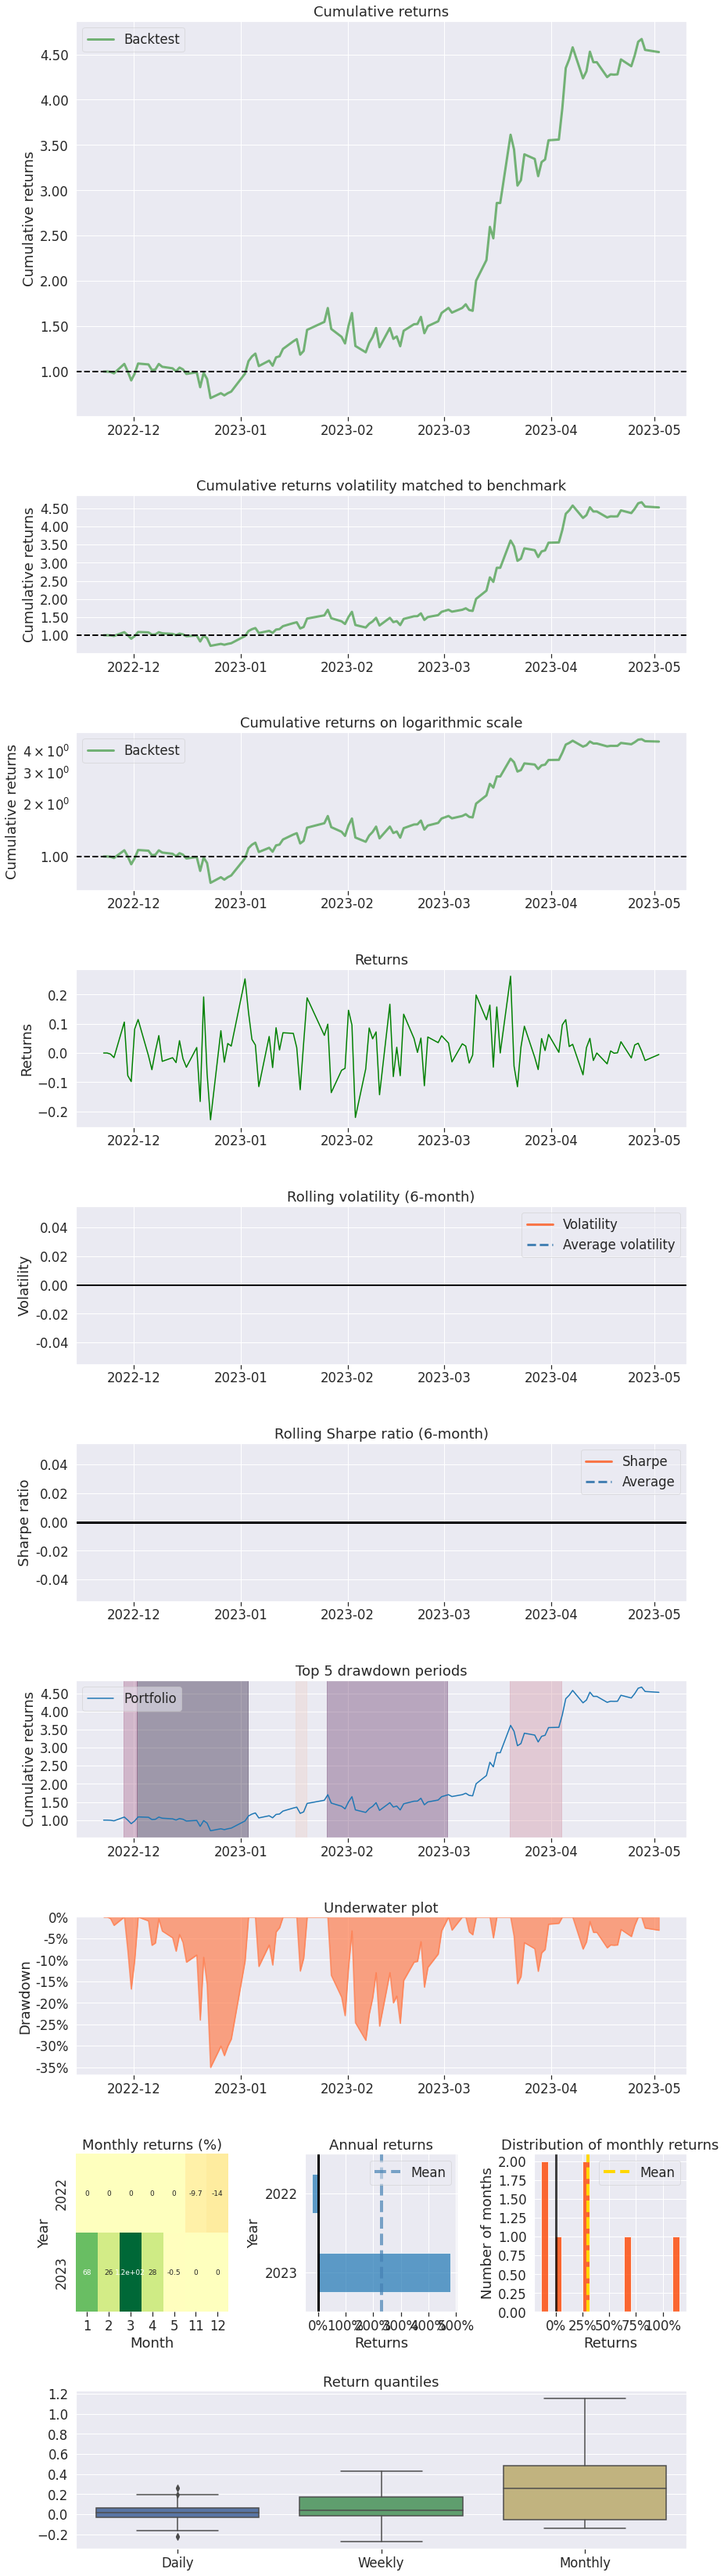

In [46]:
pf.create_returns_tear_sheet(returns)

### Bollinger Bands

In [59]:
def initialize(context):
    context.i = 0
    context.asset = symbol("Kor_gold_mod")
    context.bollinger_bands = None

def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    price_history = data.history(context.asset, 'close', 20, '1d')
    current_price = data.current(context.asset, 'close')
    sma = price_history.mean()
    std = price_history.std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    context.bollinger_bands = (lower_band, upper_band)

    if current_price <= lower_band:
        order(context.asset, 1.0)      ## Place a buy order to take advantage of the potential rebound (oversold)
        buy_signal=True
    elif current_price >= upper_band:
        order(context.asset, -1.0)     ### Place a sell order to take advantage of the potential price correction(overbought)
        sell_signal=True
    else:
        order(context.asset, 0)

    record(price=current_price, lower_band=lower_band, upper_band=upper_band)
    record(
        Kor_gold=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=price_history
    )

In [72]:
start_date = pd.to_datetime('2022-11-29', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2023-05-02', utc= True, format = '%Y-%m-%d %H:%M')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='Korea_commodity1',
                            data_frequency='daily',
                            )

/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid va

In [67]:
results

,period_open,period_close,starting_value,ending_value,starting_cash,ending_cash,returns,portfolio_value,longs_count,shorts_count,...,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta
2022-11-29 06:30:00+00:00,2022-11-29 00:01:00+00:00,2022-11-29 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,0.0,0.0,1,2022-11,0.000000,NaN,0.0,NaN,None,None
2022-11-30 06:30:00+00:00,2022-11-30 00:01:00+00:00,2022-11-30 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,0.0,0.0,2,2022-11,0.000000,0.000000,0.0,0.0,None,None
2022-12-01 06:30:00+00:00,2022-12-01 00:01:00+00:00,2022-12-01 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,0.0,0.0,3,2022-12,0.000000,0.000000,0.0,0.0,None,None
2022-12-02 06:30:00+00:00,2022-12-02 00:01:00+00:00,2022-12-02 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,0.0,0.0,4,2022-12,0.000000,0.000000,0.0,0.0,None,None
2022-12-05 06:30:00+00:00,2022-12-05 00:01:00+00:00,2022-12-05 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,0.0,0.0,5,2022-12,0.000000,0.000000,0.0,0.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 06:30:00+00:00,2023-04-25 00:01:00+00:00,2023-04-25 06:30:00+00:00,-676800.0,-680000.0,662869.275,662869.275,0.229708,-17130.725,0,1,...,0.0,0.0,102,2023-04,-2.713072,7.783591,0.0,0.0,None,None
2023-04-26 06:30:00+00:00,2023-04-26 00:01:00+00:00,2023-04-26 06:30:00+00:00,-680000.0,-684000.0,662869.275,662869.275,0.233499,-21130.725,0,1,...,0.0,0.0,103,2023-04,-3.113072,7.751389,0.0,0.0,None,None
2023-04-27 06:30:00+00:00,2023-04-27 00:01:00+00:00,2023-04-27 06:30:00+00:00,-684000.0,-684800.0,662869.275,662869.275,0.037860,-21930.725,0,1,...,0.0,0.0,104,2023-04,-3.193072,7.713669,0.0,0.0,None,None
2023-04-28 06:30:00+00:00,2023-04-28 00:01:00+00:00,2023-04-28 06:30:00+00:00,-684800.0,-681600.0,662869.275,662869.275,-0.145914,-18730.725,0,1,...,0.0,0.0,105,2023-04,-2.873072,7.681877,0.0,0.0,None,None


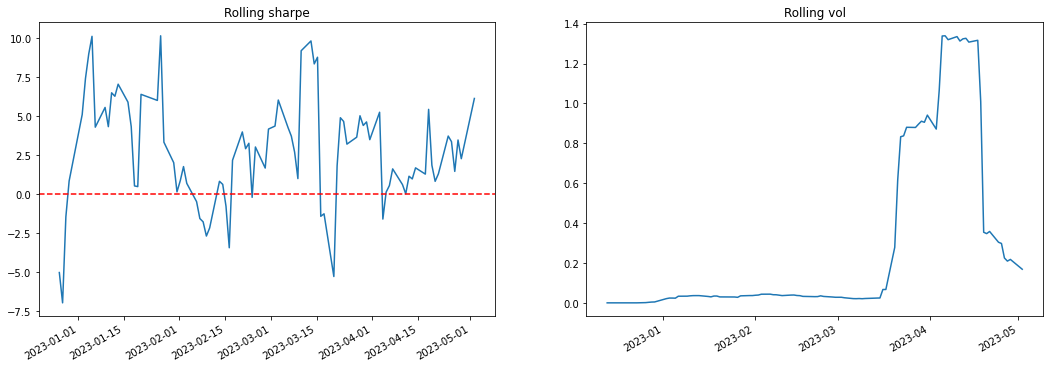

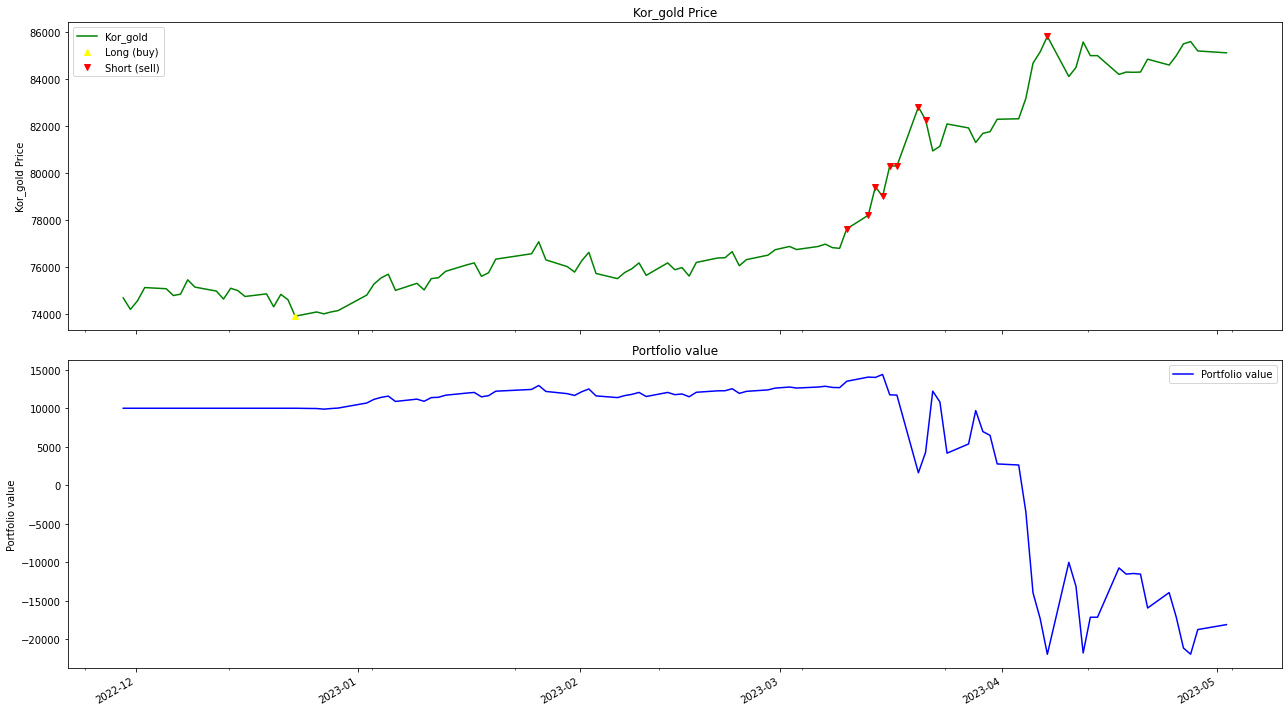

,period_open,period_close,starting_value,ending_value,starting_cash,ending_cash,returns,portfolio_value,longs_count,shorts_count,...,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,alpha,beta,rolling_sharpe,rolling_vol
2022-11-29 06:30:00+00:00,2022-11-29 00:01:00+00:00,2022-11-29 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,1,2022-11,0.000000,NaN,0.0,NaN,None,None,NaN,NaN
2022-11-30 06:30:00+00:00,2022-11-30 00:01:00+00:00,2022-11-30 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,2,2022-11,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2022-12-01 06:30:00+00:00,2022-12-01 00:01:00+00:00,2022-12-01 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,3,2022-12,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2022-12-02 06:30:00+00:00,2022-12-02 00:01:00+00:00,2022-12-02 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,4,2022-12,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
2022-12-05 06:30:00+00:00,2022-12-05 00:01:00+00:00,2022-12-05 06:30:00+00:00,0.0,0.0,10000.000,10000.000,0.000000,10000.000,0,0,...,5,2022-12,0.000000,0.000000,0.0,0.0,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25 06:30:00+00:00,2023-04-25 00:01:00+00:00,2023-04-25 06:30:00+00:00,-676800.0,-680000.0,662869.275,662869.275,0.229708,-17130.725,0,1,...,102,2023-04,-2.713072,7.783591,0.0,0.0,None,None,3.367579,0.297743
2023-04-26 06:30:00+00:00,2023-04-26 00:01:00+00:00,2023-04-26 06:30:00+00:00,-680000.0,-684000.0,662869.275,662869.275,0.233499,-21130.725,0,1,...,103,2023-04,-3.113072,7.751389,0.0,0.0,None,None,1.462302,0.224851
2023-04-27 06:30:00+00:00,2023-04-27 00:01:00+00:00,2023-04-27 06:30:00+00:00,-684000.0,-684800.0,662869.275,662869.275,0.037860,-21930.725,0,1,...,104,2023-04,-3.193072,7.713669,0.0,0.0,None,None,3.474265,0.209320
2023-04-28 06:30:00+00:00,2023-04-28 00:01:00+00:00,2023-04-28 06:30:00+00:00,-684800.0,-681600.0,662869.275,662869.275,-0.145914,-18730.725,0,1,...,105,2023-04,-2.873072,7.681877,0.0,0.0,None,None,2.275672,0.217783


In [68]:
show_rolling_stats(results, 10, buy_signal=results['buy_signal'], sell_signal=results['sell_signal'])


In [69]:
start_date = pd.to_datetime('2022-11-29', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2023-03-02', utc= True, format = '%Y-%m-%d %H:%M')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='Korea_commodity1',
                            data_frequency='daily',
                            )

/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid va

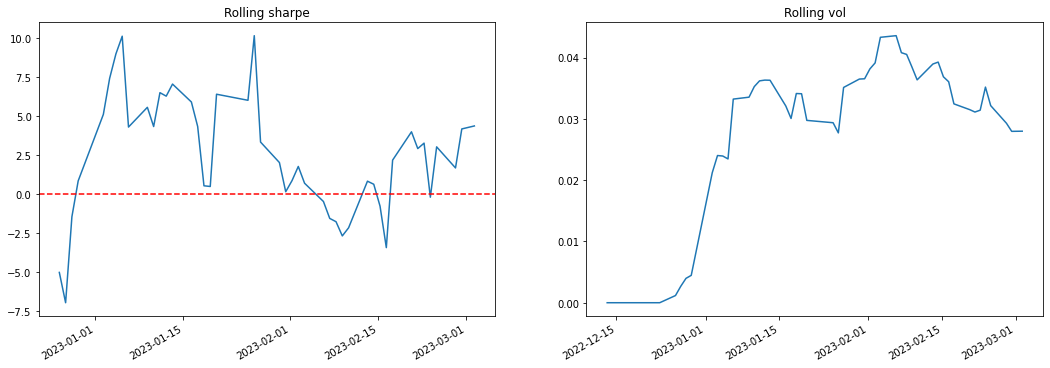

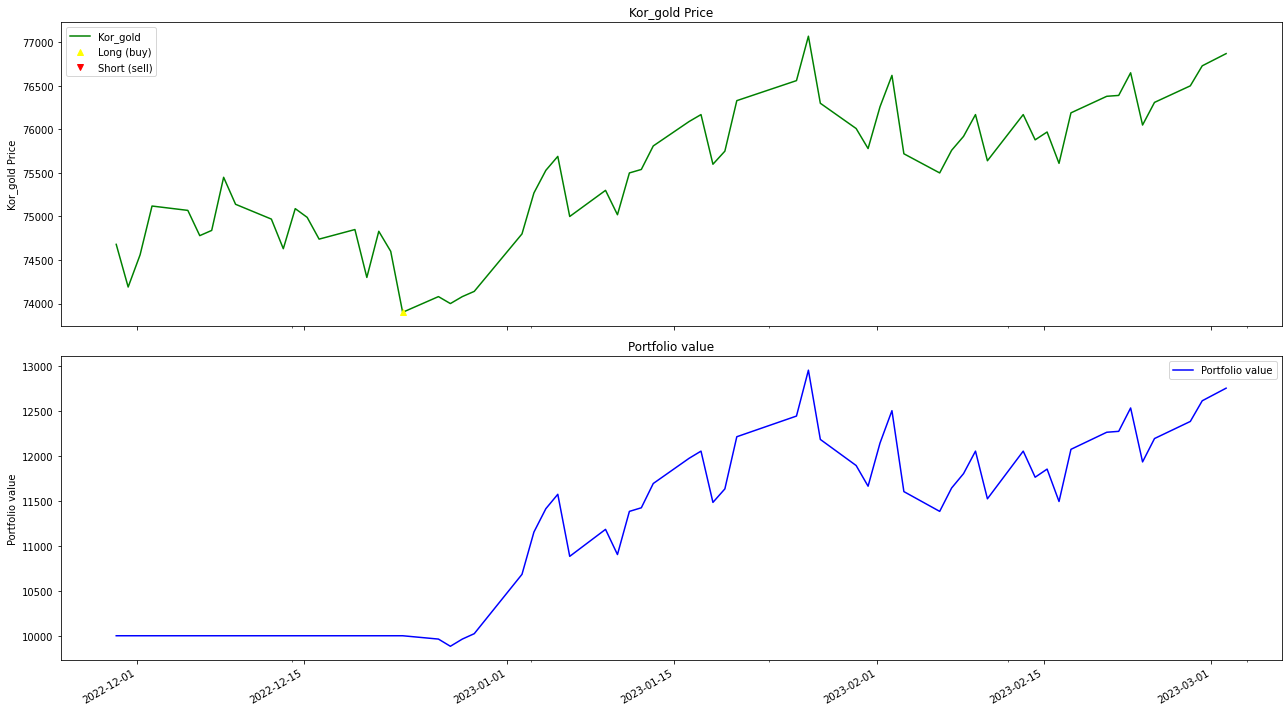

,period_open,period_close,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,capital_used,...,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,rolling_sharpe,rolling_vol
2022-11-29 06:30:00+00:00,2022-11-29 00:01:00+00:00,2022-11-29 06:30:00+00:00,10000.000,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,0.0,1,2022-11,0.000000,NaN,NaN
2022-11-30 06:30:00+00:00,2022-11-30 00:01:00+00:00,2022-11-30 06:30:00+00:00,10000.000,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,0.0,2,2022-11,0.000000,NaN,NaN
2022-12-01 06:30:00+00:00,2022-12-01 00:01:00+00:00,2022-12-01 06:30:00+00:00,10000.000,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,0.0,3,2022-12,0.000000,NaN,NaN
2022-12-02 06:30:00+00:00,2022-12-02 00:01:00+00:00,2022-12-02 06:30:00+00:00,10000.000,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,0.0,4,2022-12,0.000000,NaN,NaN
2022-12-05 06:30:00+00:00,2022-12-05 00:01:00+00:00,2022-12-05 06:30:00+00:00,10000.000,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.000000,0.000000,0.0,0.0,5,2022-12,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-23 06:30:00+00:00,2023-02-23 00:01:00+00:00,2023-02-23 06:30:00+00:00,11932.959,1,0,76050.0,0.0,76050.0,-600.0,0.0,...,2.752967,-0.121208,7.487636,0.0,0.0,60,2023-02,0.193296,-0.199823,0.035187
2023-02-24 06:30:00+00:00,2023-02-24 00:01:00+00:00,2023-02-24 06:30:00+00:00,12192.959,1,0,76310.0,0.0,76310.0,260.0,0.0,...,3.027274,-0.121208,7.487636,0.0,0.0,61,2023-02,0.219296,3.027163,0.032163
2023-02-27 06:30:00+00:00,2023-02-27 00:01:00+00:00,2023-02-27 06:30:00+00:00,12382.959,1,0,76500.0,0.0,76500.0,190.0,0.0,...,3.213428,-0.121208,7.487636,0.0,0.0,62,2023-02,0.238296,1.676138,0.029283
2023-02-28 06:30:00+00:00,2023-02-28 00:01:00+00:00,2023-02-28 06:30:00+00:00,12612.959,1,0,76730.0,0.0,76730.0,230.0,0.0,...,3.436925,-0.121208,7.487636,0.0,0.0,63,2023-02,0.261296,4.175335,0.027965


In [70]:
show_rolling_stats(results, 10, buy_signal=results['buy_signal'], sell_signal=results['sell_signal'])


/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/timeseries.py:734: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarn

Start date,2022-11-29
End date,2023-05-02
Total months,5
,Backtest
Annual return,nan%
Cumulative returns,-280.907%
Annual volatility,764.602%
Sharpe ratio,1.23
Calmar ratio,NaN
Stability,NaN
Max drawdown,-252.514%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,252.51,2023-03-15,2023-04-07,NaT,NaN
1,12.12,2023-01-26,2023-02-06,2023-03-10,32
2,5.96,2023-01-05,2023-01-06,2023-01-13,7
3,4.73,2023-01-17,2023-01-18,2023-01-20,4
4,1.17,2022-12-23,2022-12-27,2022-12-29,5


/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mehedi/miniconda3/envs/fa1/lib/python3.9/site-packages/matplotlib/dates.py:446: DeprecationWarning: parsing timezone aware datetimes is deprecated; thi

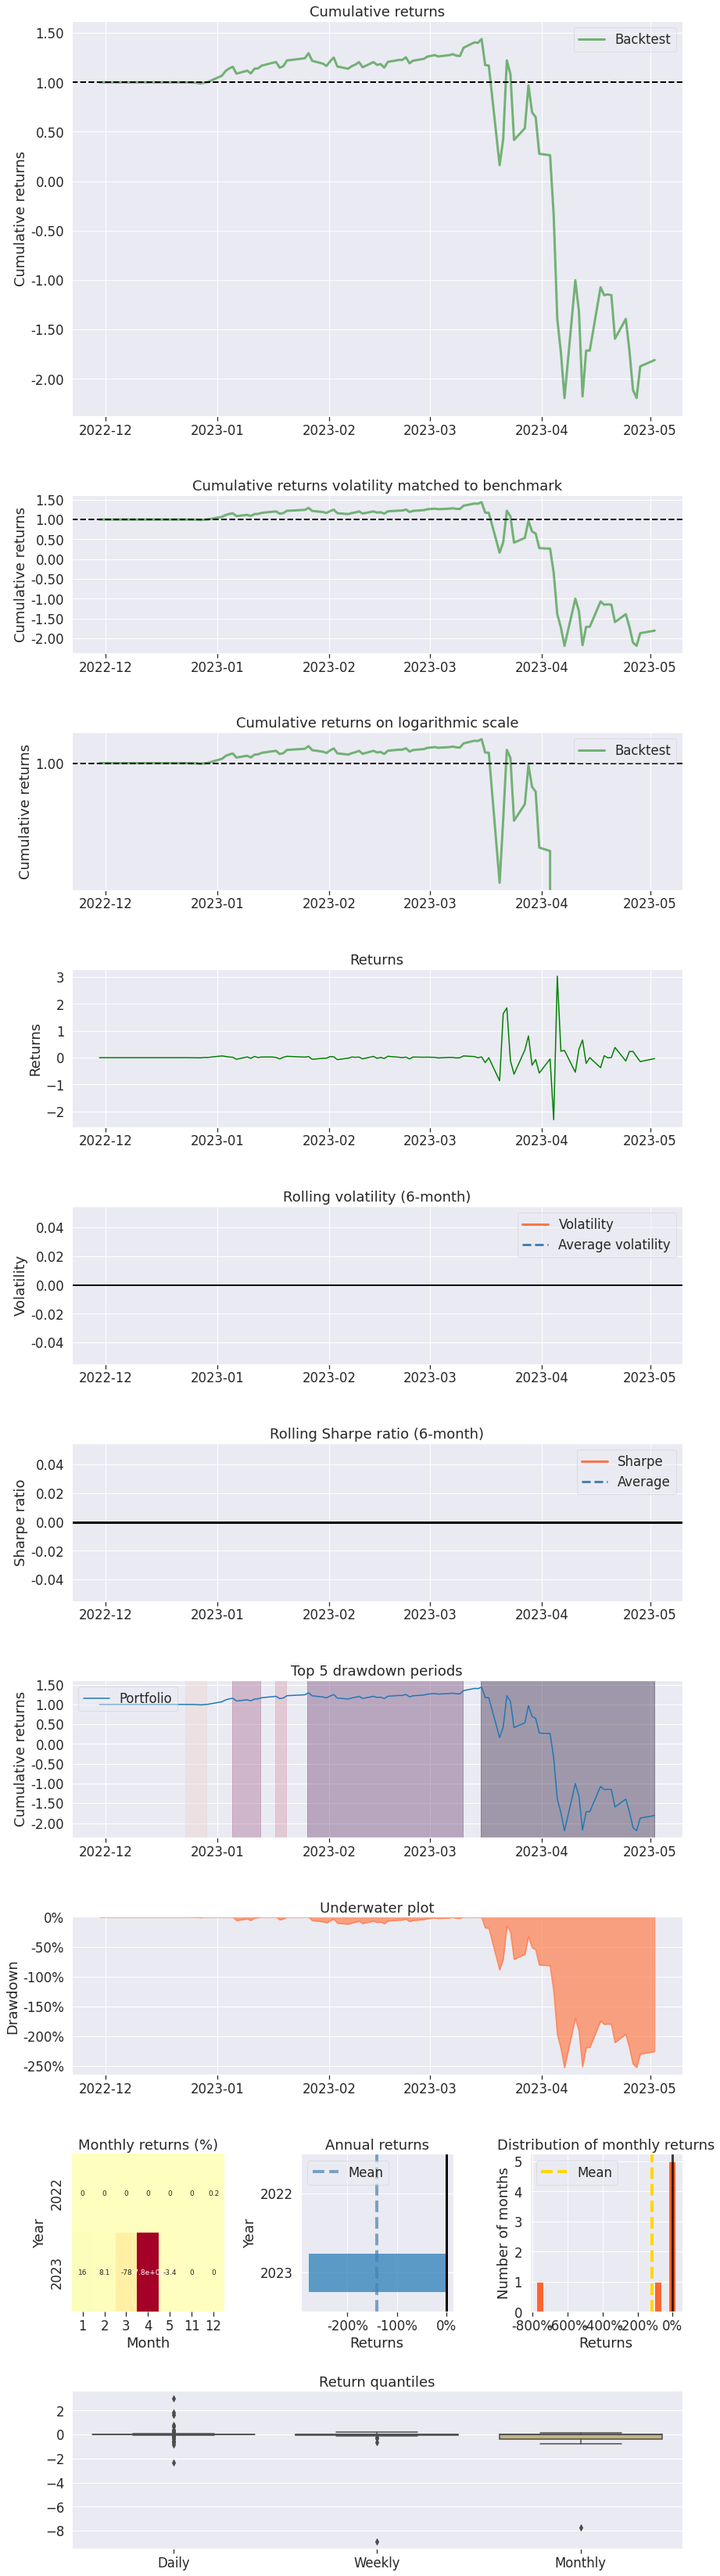

In [73]:
returns = results['returns']
pf.create_returns_tear_sheet(returns)